# AIS Dataset 

What is AIS dataset?
Vessel traffic data, or Automatic Identification System (AIS) data, are collected by the U.S. Coast Guard through an onboard navigation safety device that transmits and monitors the location and characteristics of vessels in U.S. and international waters in real time.

AIS (Automatic Identification System) marine dataset can be used detect the type of ship by analyzing the data and identifying patterns that correspond to specific ship types

Stages to be followed: 

Data collection: The first step is to collect AIS data from various sources, such as AIS receivers, satellite imagery, or other publicly available datasets.

Data preprocessing: Once the data is collected, it needs to be cleaned and preprocessed. This involves removing any irrelevant data, filling in missing values, and converting the data into a format that can be used by machine learning algorithms.

Feature engineering: In this step, relevant features are extracted from the preprocessed data. For example, features such as ship speed, heading, size, and location can be used to identify the ship type.

Machine learning algorithm selection: After the features are extracted, a suitable machine learning algorithm is selected based on the nature of the problem. For example, a supervised learning algorithm like a decision tree or random forest can be used to classify the ships based on their features.

Model training and validation: The selected machine learning algorithm is then trained on a portion of the data and validated on another portion of the data to test its accuracy.

###1. Data Collection

In [10]:
import pandas as pd
import numpy as np 

df_raw = pd.read_csv("ais_data.csv")
print(df_raw.info())
print(df_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358351 entries, 0 to 358350
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          358351 non-null  int64  
 1   mmsi                358351 non-null  int64  
 2   navigationalstatus  358351 non-null  object 
 3   sog                 357893 non-null  float64
 4   cog                 355182 non-null  float64
 5   heading             337737 non-null  float64
 6   shiptype            358351 non-null  object 
 7   width               354640 non-null  float64
 8   length              354608 non-null  float64
 9   draught             332808 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 27.3+ MB
None
          Unnamed: 0          mmsi            sog            cog  \
count  358351.000000  3.583510e+05  357893.000000  355182.000000   
mean   186757.775285  2.939678e+08      12.122554     189.064529   
std    112181.601

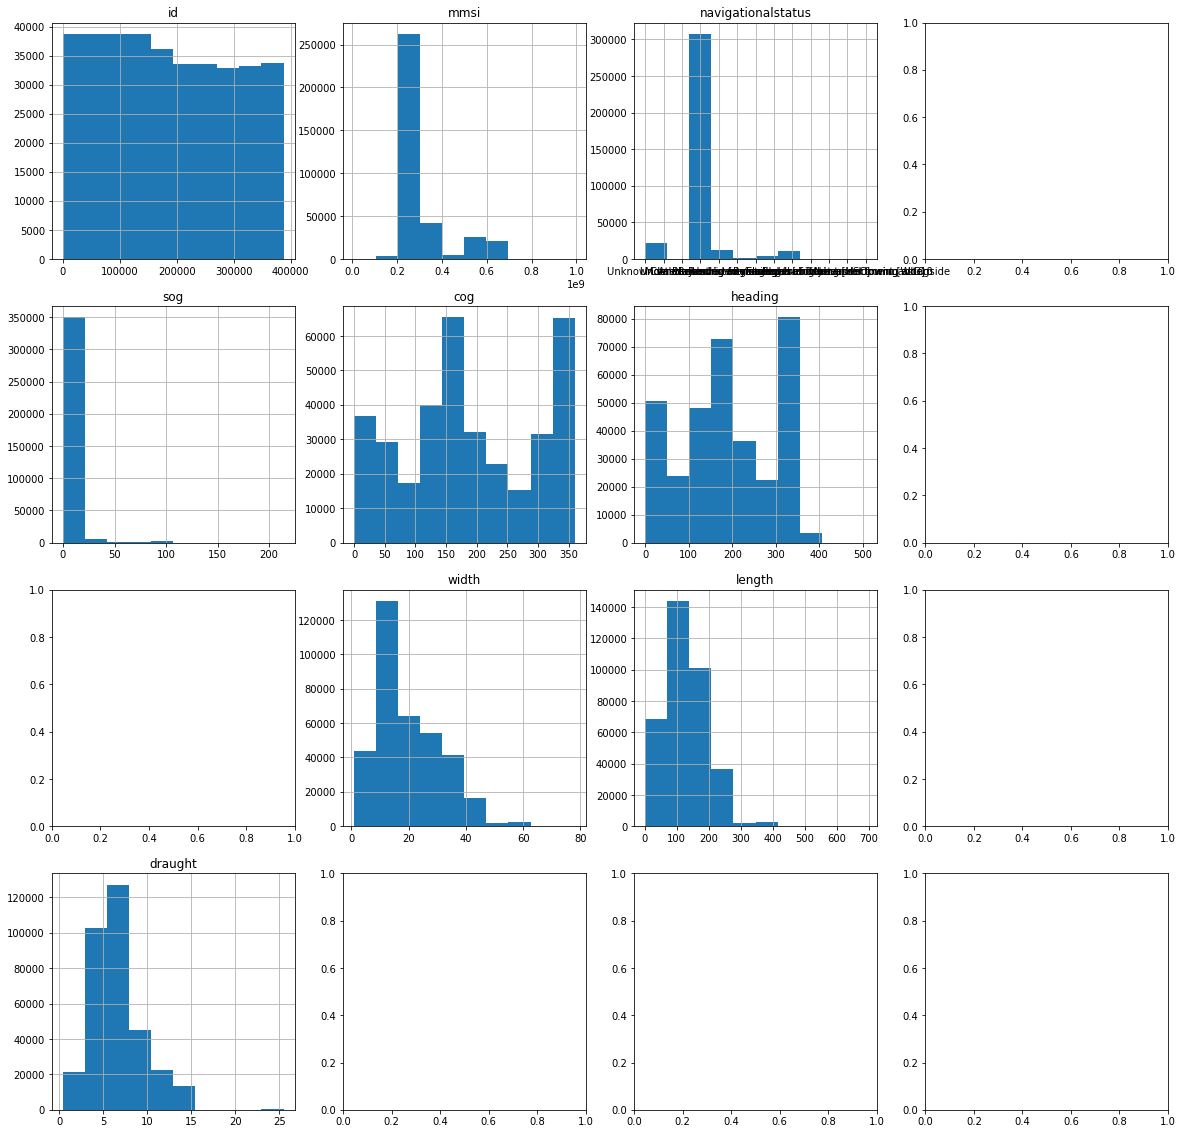

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline 
df_raw.rename(columns={'Unnamed: 0':'id'}, inplace=True)
fig,ax = plt.subplots(4,4)

fig.set_size_inches(20,20)
for i,col in enumerate(df_raw.columns):
  if col != 'shiptype':
    df_raw[col].hist(ax=ax[i//3,i%3])
    ax[i//3,i%3].set_title(col)


###2. Preprocessing using sklearn pipelines

In [12]:
import pandas as pd
import numpy as np
import os 
import sys 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
#change default path to the root of the project

filename = "ais_data.csv"
def preprocess_data(data_path,expected_columns,target):
    df_raw = pd.read_csv(data_path)

  
    for col in expected_columns:
        if col not in df_raw.columns:
            raise ValueError(f"Column {col} not found in the dataframe")
    y = df_raw.pop(target)
    y = pd.factorize(y)[0]
    
    #add boolean fields if the columns has value of na 
    columns_names = df_raw.columns
    for col in columns_names:
        if df_raw[col].isna().any():
            df_raw[f'{col}_is_na'] = df_raw[col].isna()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('one_hot_encoder', OneHotEncoder()),
    ])

    preprocessing = make_column_transformer(
        (num_pipeline, make_column_selector(dtype_include=np.number)),
        (cat_pipeline, make_column_selector(dtype_include=object)),
    )
    preprocessing.fit(df_raw)
    joblib.dump(preprocessing,"preprocessing.pkl")
    X = preprocessing.fit_transform(df_raw)
    return X,y
expected_columns = ['mmsi', 'navigationalstatus', 'sog', 'cog', 'heading', 'shiptype','width','length','draught']
target= 'shiptype'
X,y = preprocess_data(filename,expected_columns,target)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###3. Model development

We will use accuracy, F1, AUC as metrics for this excerise

In [13]:
def print_metrics(y,y_pred):
    #calculate accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y,y_pred)
    #calculate f1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y,y_pred,average='weighted')
    #calculate auc
    
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
  

    

In [19]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

def train_xgb(X_train,X_test,y_train,y_test):
  
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)
  param = {'max_depth':10,  'objective':'multi:softmax','num_class':len(np.unique(y_train))}
  num_round = 3
  bst = xgb.train(param, dtrain, num_round)
  preds = bst.predict(dtest)
  print_metrics(y_test,preds)
  joblib.dump(bst,"xboost_model.pkl")

def train_logistic_regression(X_train,X_test,y_train,y_test):
    #fit multiclass problem to logistic regression
    lr = LogisticRegression()
    lr.fit(X_train,y_train)
    #predict on the same data
    y_pred = lr.predict(X_test)
    print_metrics(y_test,y_pred)
    joblib.dump(lr,"lr_model.pkl")

def train_random_forest(X_train,X_test,y_train,y_test):
    #fit multiclass problem to random forest
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    #predict on the same data
    y_pred = rf.predict(X_test)
    print_metrics(y_test,y_pred)
    #pickle the model
    joblib.dump(rf, 'rf.pkl')



train_xgb(X_train,X_test,y_train,y_test)
train_logistic_regression(X_train,X_test,y_train,y_test)
train_random_forest(X_train,X_test,y_train,y_test)


Accuracy: 0.9578630129341017
F1: 0.9575685642902245


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6952184286531512
F1: 0.6569930696423617
Accuracy: 0.9965536967532196
F1: 0.996563228152272


###4. Developing TF models

In [14]:
import pandas as pd
import numpy as np
import os 
import sys 

import tensorflow as tf
import pickle
#get test train split from sklearn
from sklearn.model_selection import train_test_split
import joblib

filename = "ais_data.csv"
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

preprocessing_path = "preprocessing.pkl"

def create_dataset(data_path,expected_columns, preprocessing_path,target, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE):
    df_raw = pd.read_csv(data_path)
    #drop Unnamed: 0 column
    
    for col in expected_columns:
        if col not in df_raw.columns:
            raise ValueError(f"Column {col} not found in the dataframe")
    columns_names = df_raw.columns
    for col in columns_names:
        if df_raw[col].isna().any():
            df_raw[f'{col}_is_na'] = df_raw[col].isna()

    y = df_raw.pop(target)
    #convert y to numerical values
    y = pd.factorize(y)[0]
    #convert y to float32
    y = y.astype('float32')
       


    preprocessing = joblib.load(preprocessing_path)
    #transform the data
    X = preprocessing.transform(df_raw)
    #convert X to float32
    X = np.asarray(X.astype('float32'))
    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    n_rows,n_cols= X.shape
   
    return train_dataset, test_dataset,n_rows,n_cols



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 21)               43        
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 64)                1408      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 17)                2193      
                                                                 
Total params: 28,476
Trainable params: 28,433
Non-trainable params: 43
_________________________________________________

<Figure size 432x288 with 0 Axes>

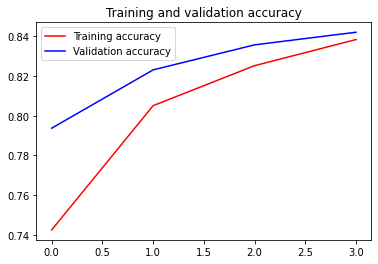

<Figure size 432x288 with 0 Axes>

In [18]:
import tensorflow as tf

data_path = "ais_data.csv"
expected_columns = ['mmsi', 'navigationalstatus', 'sog', 'cog', 'heading', 'shiptype','width','length','draught']

train_dataset, test_dataset,n_rows,n_cols = create_dataset(data_path,expected_columns,preprocessing_path,'shiptype')

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(train_dataset.map(lambda x, y: x))
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='selu', input_shape=(n_cols,)),
    
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dense(17, activation='softmax')
])
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    #save the best model
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True), 
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)
]

print(model.summary())

model.compile(loss = 'sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=4, validation_data=test_dataset,callbacks=callbacks)

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()